In [17]:
import sys
import time
import numpy as np
import pylab as pl

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module, Balloon_Simulator
from vent.common.message import SensorValues, ControlSetting, Alarm, AlarmSeverity
from vent.common.values import ValueName, CONTROL

In [18]:
import inspect
inspect.getfile(Balloon_Simulator)

'/Users/ms81/Ventilator-Dev/vent/controller/control_module.py'

In [19]:
Controller = get_control_module(sim_mode=True)

In [20]:
Controller.start()

ls = []
tt = []
t0 = time.time()
for t in np.arange(0, 30,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        print(Controller.heartbeat())
    
    
    ## Do things
    
    
    ##
    
    
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time()  - t0)
    
    time.sleep(0.05)
    
Controller.stop()

0
455
902
1353
1787
2231


Text(0.5, 0, 'time [s]')

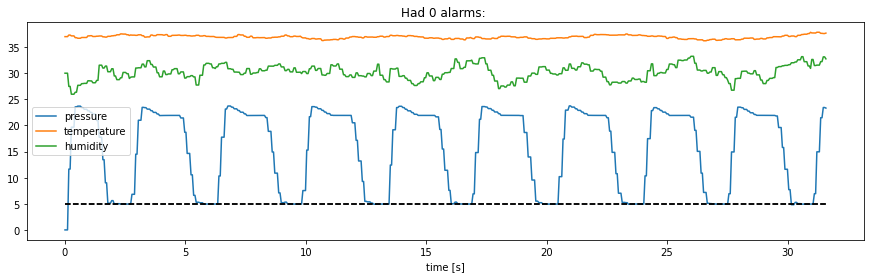

In [21]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ValueName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ValueName.PEEP)
pip = cc.value

pl.plot(tt, [s.pressure for s in ls], label = 'pressure')
pl.plot(tt, [s.temp for s in ls], label = "temperature")
pl.plot(tt, [s.humidity/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')

active_alarms = Controller.get_active_alarms()
logged_alarms = Controller.get_logged_alarms()

pc = 0
for active_alarm_key in active_alarms.keys():
    alarm = active_alarms[active_alarm_key]
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25], 'r-')
    pc += 0.1

pc=0
for alarm in logged_alarms:
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_start_time-t0+pc], [0,25-7*pc], 'b-')
    pl.plot([alarm.alarm_start_time-t0+pc, alarm.alarm_end_time-t0+pc],  [25-7*pc,25-7*pc], 'b-')
    pc += 0.1

s = "Had " + str(len(Controller.get_alarms())) + " alarms: "
for alarm in Controller.get_alarms():
    s = s + alarm.alarm_name + ", "
    
pl.title(s)
pl.legend()
pl.xlabel("time [s]")

# Balloon tests

In [1]:
import sys
import time
import numpy as np
import pylab as pl

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module, Balloon_Simulator
from vent.common.message import SensorValues, ControlSetting, Alarm, AlarmSeverity
from vent.common.values import ValueName, CONTROL

In [15]:
dt = 0.1
times = np.arange(0,20,dt)

Qin = 0.2

Patient = Balloon_Simulator(leak=False)

ls_pressure = []
ls_volume  = []

for t in times:  # in seconds
    Qout = np.sin(t)>-0.5
    Patient.set_flow_in(Qin, dt)    # How much air goes into the ballon in this timestep in liters/sec
    Patient.set_flow_out(Qout, dt)    # How much air goes into the ballon in this timestep in liters/sec

    Patient.update(dt)
    
    ls_pressure = np.append(ls_pressure, Patient.get_pressure())
    ls_volume = np.append(ls_volume, Patient.get_volume())

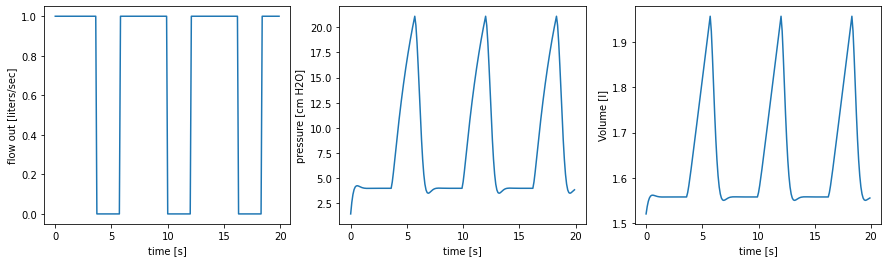

In [16]:
pl.rcParams['figure.figsize'] = [15, 4]

pl.subplot(1,3,1)
pl.plot(times, np.sin(times)>-0.5  )
pl.ylabel("flow out [liters/sec]")
pl.xlabel("time [s]")

pl.subplot(1,3,2)
pl.plot(times, ls_pressure)
pl.ylabel("pressure [cm H2O]")
pl.xlabel("time [s]")

pl.subplot(1,3,3)
pl.plot(times, ls_volume)
pl.ylabel("Volume [l]")
pl.xlabel("time [s]");

In [11]:
Patient.Qout

0.2001361336854253